In [1]:
import re
import glob
import json
import numpy as np
import pandas as pd
import geopandas as gpd

from tqdm import tqdm

import plotly.express as px
import matplotlib.pyplot as plt

import plotly.io as pio
pio.renderers.default = "iframe"

# Гео-данные станций

In [2]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [3]:
posts_df = pd.read_csv('../data/Датасет_04/02_координаты_станций.csv', sep=';', names=['post_name', 'latitude', 'longitude'])
posts = gpd.GeoDataFrame(
                posts_df, geometry=gpd.points_from_xy(posts_df.longitude, posts_df.latitude))

In [4]:
posts

,post_name,latitude,longitude,geometry
0,Академика,55.658163,37.471434,POINT (37.47143 55.65816)
1,Бутлерова,55.649412,37.535874,POINT (37.53587 55.64941)
2,Глебовская,55.811801,37.712490,POINT (37.71249 55.81180)
3,Коптевскии,55.833222,37.525158,POINT (37.52516 55.83322)
4,Марьино,55.652695,37.751502,POINT (37.75150 55.65270)
5,Останкино,55.821154,37.612592,POINT (37.61259 55.82115)
6,Пролетарскии,55.635129,37.658684,POINT (37.65868 55.63513)
7,Спиридоновка,55.759354,37.595584,POINT (37.59558 55.75935)
8,Туристская,55.856324,37.426628,POINT (37.42663 55.85632)
9,Шаболовка,55.715698,37.605238,POINT (37.60524 55.71570)


In [5]:
gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

In [6]:
ao = gpd.read_file('../data/geo/ao.geojson')
mo = gpd.read_file('../data/geo/mo.geojson')

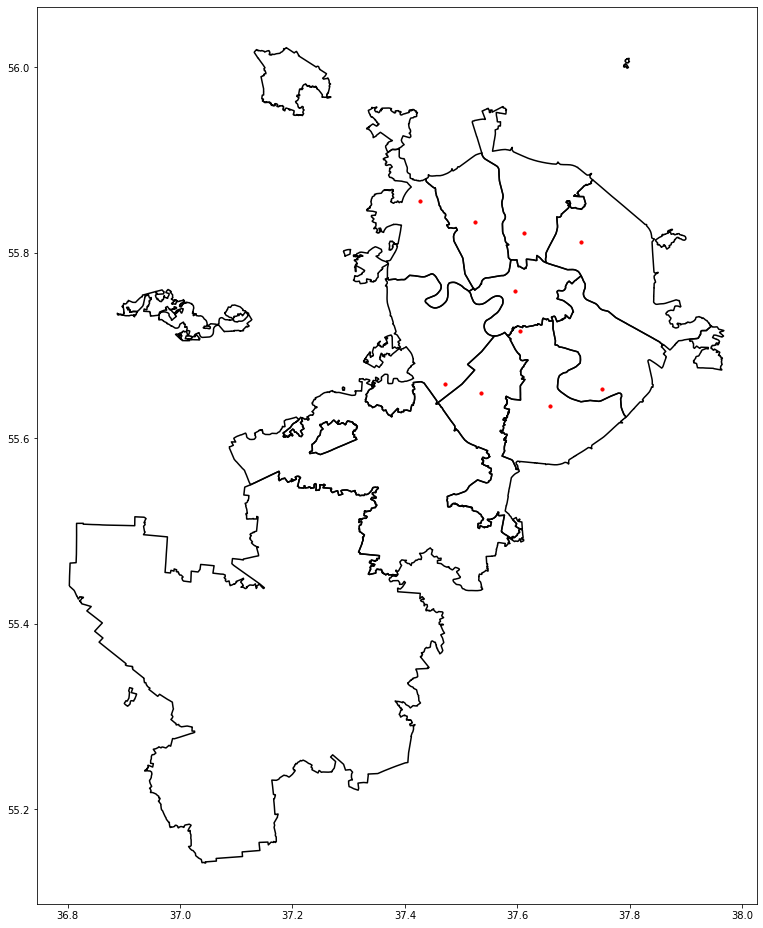

In [7]:
fig, ax = plt.subplots()

ao.boundary.plot(ax=ax, color='black', edgecolor='black')
#mo.boundary.plot(ax=ax, color='black', edgecolor='grey')
posts.plot(ax=ax, marker='o', color='red', markersize=10, aspect=1.65)
set_size(10,20)

plt.show()

# Измерения показаталей

In [8]:
datasets = {}
files = glob.glob('../data/Датасет_04/01_данные станций/[А-Я]*.xlsx')

for file in tqdm(files):
    name = re.findall(r'\w+', file)[4]
    data = pd.read_excel(file)
    data['Дата и время'] = pd.to_datetime(data['Дата и время'])
    #print(file, data.shape)
    data.dropna(subset=['Дата и время'], inplace=True)
    data.drop(data.loc[data['Дата и время'] >= '2021-01-01 00:00:00'].index, inplace=True)
    #print(file, data.shape)
    data = data.sort_values(by='Дата и время')
    datasets[name] = data

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.29s/it]


In [9]:
def plot_report(data):
    fig, axs = plt.subplots(5)

    axs[0].plot(data['Дата и время'], data['CO'])

    axs[1].plot(data['Дата и время'], data['NO2'])
    axs[1].plot(data['Дата и время'], data['NO'])
    axs[1].plot(data['Дата и время'], data['PM10'])

    axs[2].plot(data['Дата и время'], data['Осадки'])
    axs[2].plot(data['Дата и время'], data['-T-'])
    axs[2].plot(data['Дата и время'], data['| V |'])

    axs[3].plot(data['Дата и время'], data['Давление'])

    axs[4].plot(data['Дата и время'], data['Влажность'])



    axs[0].legend(['CO'])
    axs[1].legend(['NO2', 'NO', 'PM10'])
    axs[2].legend(['Осадки', '-T-', '| V |'])
    axs[3].legend(['Давление'])
    axs[4].legend(['Влажность'])

    set_size(25,15)

In [10]:
datasets.keys()

dict_keys(['Коптевскии', 'Глебовская', 'Останкино', 'Академика', 'Спиридоновка', 'Шаболовка', 'Туристская', 'Бутлерова', 'Пролетарскии', 'Марьино'])

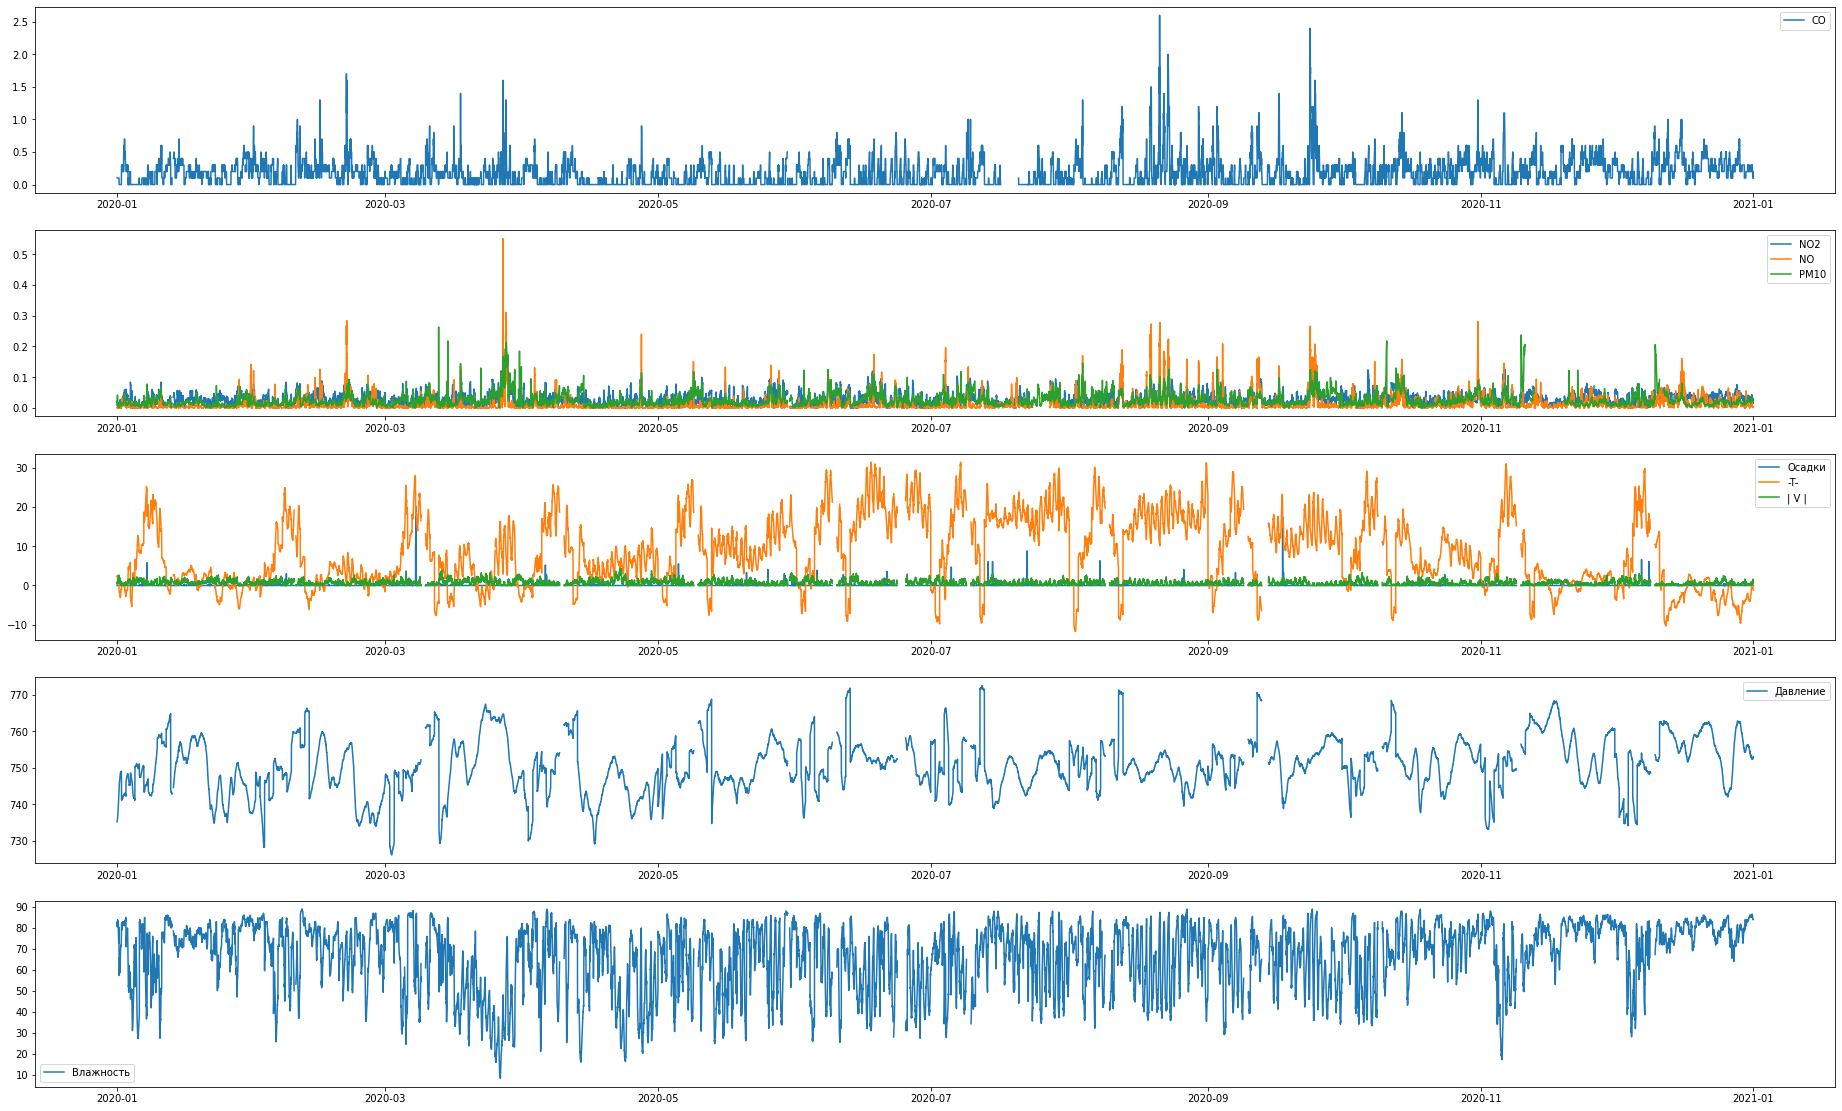

In [11]:
plot_report(datasets['Марьино'])

In [12]:
t_cols = ['Дата и время', 'CO', 'NO2', 'NO', '-T-',
           '| V |', '_V_', 'Давление', 'Влажность', 'Осадки', 'latitude',
           'longitude', 'post_name']
tmp_slice = pd.DataFrame(columns=t_cols)

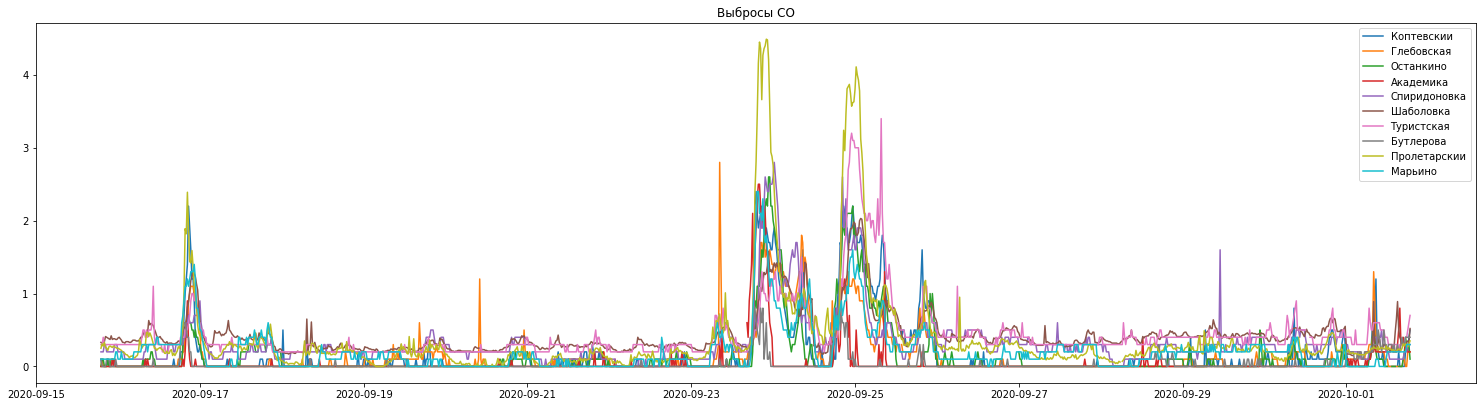

In [13]:
fig, axs = plt.subplots(1)

# keys = ['Бутлерова', 'Пролетарскии', 'Марьино', 'Туристская', 'Глебовская']
keys = datasets.keys()
for key in keys:
    mask = (datasets[key]['Дата и время'] >= '2020-09-15 19:00:00') & (datasets[key]['Дата и время'] < '2020-10-01 19:00:00')
    axs.plot(datasets[key][mask==True]['Дата и время'], datasets[key][mask==True]['CO'])
    tmp = datasets[key][mask==True].copy()
    tmp2 = posts_df.query('post_name == @key')

    tmp['latitude'] = tmp2['latitude'].values[0]
    tmp['longitude'] = tmp2['longitude'].values[0]
    tmp['post_name'] = tmp2['post_name'].values[0]
    
    tmp_slice = pd.concat([tmp_slice, tmp[t_cols]])


axs.legend(keys)
axs.set_title('Выбросы CO')
set_size(20,5)

In [14]:
target_post = 'Марьино'
target = 'CO_0'

data = tmp_slice.query('post_name == @target_post').copy()
data = data.reset_index(drop=True).set_index('Дата и время').rename(columns={'CO': 'CO_{}'.format(0)})
CO_val = data[['CO_0']]
CO_val.head()

,CO_0
Дата и время,
2020-09-15 19:00:00,0.1
2020-09-15 19:20:00,0.1
2020-09-15 19:40:00,0.1
2020-09-15 20:00:00,0.1
2020-09-15 20:20:00,0.1


In [15]:
i = 1
for key in (datasets.keys()):
    if key != target_post:
        new_name = 'CO_{}'.format(i)
        tmp = tmp_slice.query('post_name == @key')
        tmp = tmp.reset_index(drop=True).set_index('Дата и время').rename(columns={'CO': new_name})
        CO_val = pd.concat([CO_val, tmp[[new_name]]], axis=1)
        i += 1
        
prev_cols = ['prev_{}'.format(i) for i in range(10)]
diff_cols = ['dif_{}'.format(i) for i in range(10)]
t_cols = CO_val.columns

CO_val[prev_cols] = CO_val.shift()
CO_val[diff_cols] = CO_val[t_cols].diff()
CO_val = CO_val.dropna()
CO_val.head()

,CO_0,CO_1,CO_2,CO_3,CO_4,CO_5,CO_6,CO_7,CO_8,CO_9,...,dif_0,dif_1,dif_2,dif_3,dif_4,dif_5,dif_6,dif_7,dif_8,dif_9
Дата и время,,,,,,,,,,,,,,,,,,,,,
2020-09-15 19:20:00,0.1,0.0,0.1,0.1,0.0,0.2,0.32,0.3,0.0,0.31,...,0.0,-0.1,0.1,0.1,0.0,0.0,-0.01,0.0,-0.1,0.06
2020-09-15 19:40:00,0.1,0.0,0.0,0.1,0.0,0.2,0.33,0.4,0.0,0.28,...,0.0,0.0,-0.1,0.0,0.0,0.0,0.01,0.1,0.0,-0.03
2020-09-15 20:00:00,0.1,0.0,0.0,0.0,0.0,0.3,0.34,0.3,0.0,0.33,...,0.0,0.0,0.0,-0.1,0.0,0.1,0.01,-0.1,0.0,0.05
2020-09-15 20:20:00,0.1,0.0,0.0,0.0,0.0,0.3,0.41,0.3,0.0,0.26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,-0.07
2020-09-15 20:40:00,0.1,0.0,0.0,0.0,0.0,0.2,0.40,0.3,0.1,0.25,...,0.0,0.0,0.0,0.0,0.0,-0.1,-0.01,0.0,0.1,-0.01


In [16]:
#CO_val['CO_8'] = 1.3 * CO_val['CO_8']
t_cols.to_list() + ['dif_0', 'prev_0']

['CO_0',
 'CO_1',
 'CO_2',
 'CO_3',
 'CO_4',
 'CO_5',
 'CO_6',
 'CO_7',
 'CO_8',
 'CO_9',
 'dif_0',
 'prev_0']

In [17]:
split_dt = '2020-09-24 19:00:00'
split = len(CO_val[:split_dt])

X_train = CO_val[:split_dt].drop(t_cols.to_list() + ['dif_0', 'prev_0'], axis = 1)
y_train = CO_val.loc[:split_dt, target]

X_test = CO_val[split_dt:].drop(t_cols.to_list() + ['dif_0', 'prev_0'], axis = 1)
y_test = CO_val.loc[split_dt:, target]

In [18]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
reg = LinearRegression().fit(X_train, y_train)

In [21]:
cdf = pd.DataFrame(reg.coef_, X_train.columns, columns=['Coefficients']).sort_values(by='Coefficients', ascending=False)
cdf

,Coefficients
prev_8,0.538504
prev_6,0.395192
dif_9,0.373863
prev_7,0.368149
dif_3,0.308379
dif_8,0.279723
prev_9,0.242939
dif_7,0.241635
prev_1,0.229511
dif_4,0.115009


In [22]:
pred = reg.predict(X_test)

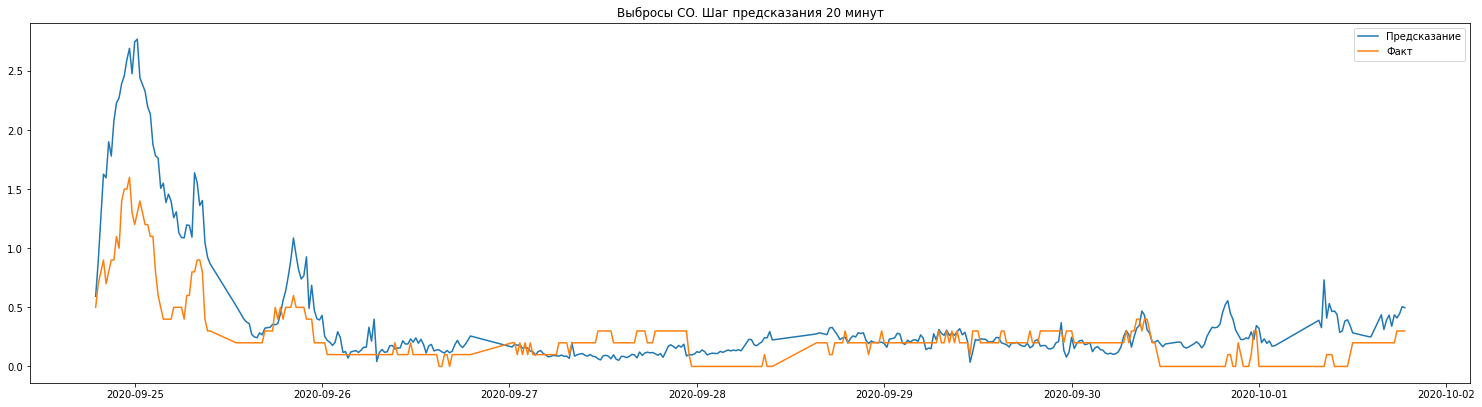

In [23]:
fig, ax = plt.subplots(1)

ax.plot(y_test.index, pred)
ax.plot(y_test.index, y_test.values)
ax.legend(['Предсказание', 'Факт'])
ax.set_title('Выбросы CO. Шаг предсказания 20 минут')

set_size(20,5)

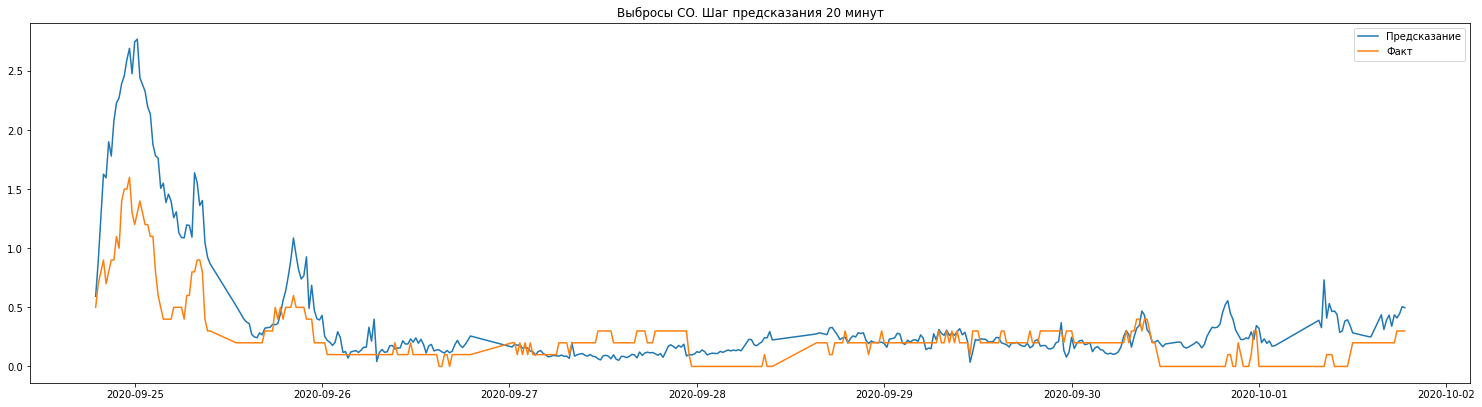

In [24]:
fig, ax = plt.subplots(1)

ax.plot(y_test.index, pred)
ax.plot(y_test.index, y_test.values)
ax.legend(['Предсказание', 'Факт'])
ax.set_title('Выбросы CO. Шаг предсказания 20 минут')

set_size(20,5)

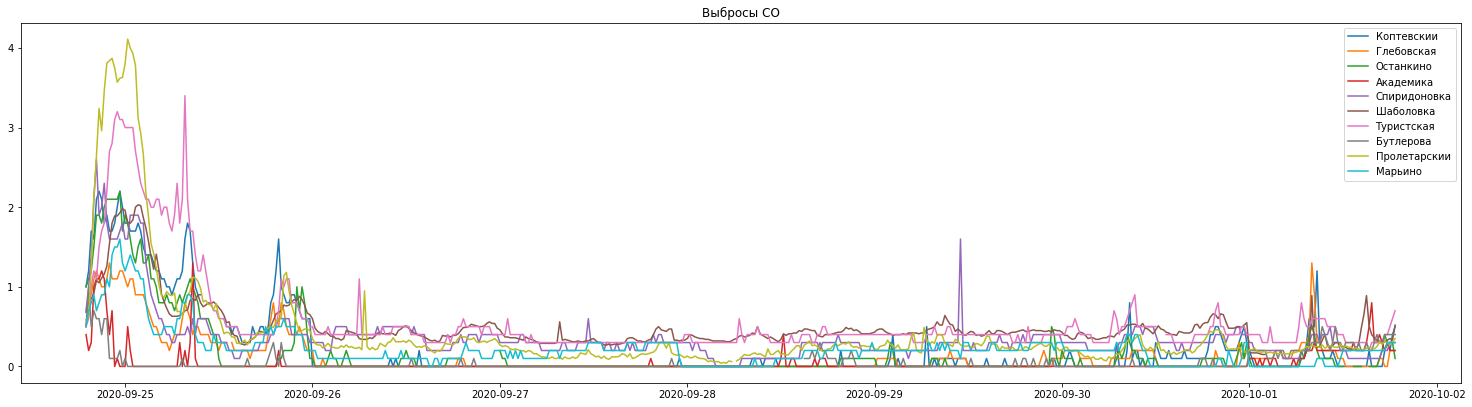

In [25]:
t_cols_ = ['Дата и время', 'CO', 'NO2', 'NO', '-T-',
           '| V |', '_V_', 'Давление', 'Влажность', 'Осадки', 'latitude',
           'longitude', 'post_name']
fig, axs = plt.subplots(1)

# keys = ['Бутлерова', 'Пролетарскии', 'Марьино', 'Туристская', 'Глебовская']
keys = datasets.keys()
for key in keys:
    mask = (datasets[key]['Дата и время'] >= split_dt) & (datasets[key]['Дата и время'] < '2020-10-01 19:00:00')
    axs.plot(datasets[key][mask==True]['Дата и время'], datasets[key][mask==True]['CO'])
    tmp = datasets[key][mask==True].copy()
    tmp2 = posts_df.query('post_name == @key')

    tmp['latitude'] = tmp2['latitude'].values[0]
    tmp['longitude'] = tmp2['longitude'].values[0]
    tmp['post_name'] = tmp2['post_name'].values[0]
    
    tmp_slice = pd.concat([tmp_slice, tmp[t_cols_]])


axs.legend(keys)
axs.set_title('Выбросы CO')
set_size(20,5)